In [48]:
import random
import time
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from collections import deque
from pprint import pprint
from enum import Enum
from typing import Union

# IPython
from IPython.display import clear_output

#ML
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers

In [49]:
class Math:
    @staticmethod
    def distance(x1, x2, y1, y2):
        return np.sqrt( np.power( (x2-x1), 2.) + np.power( (y2-y1), 2.) )

In [50]:
class ActionType(Enum):
    MOVEMENT = 0
    ACTION = 1

@dataclass
class Action:
    type: ActionType
    value: Union[int, str]

In [51]:
# Environment

@dataclass
class QSettings():
    epsilon: float
    epsilon_min = 0.01
    epsilon_decay = 0.99
    discount: float
    learning_rate: float
     
    
@dataclass
class Timer:
    start: float
    end: float
    timer: float
        
        
class RunInfo:
    def __init__(self, nepisodes, ntimes):
        self.timerstart = None
        self.timerend = None
        self.timertime = None
        
        self.scores = {str(i):[] for i in range(nepisodes)}
    
    def start_timer(self):
        self.timerstart = time.time()
    
    def end_timer(self):
        if self.timerstart is not None:
            self.timerend = time.time()
            self.timertime = self.timerend - self.timerend
    
    def get_timer(self):
        if self.timertime is not None:
            return self.timerend - self.timerstart
        else:
            raise ValueError("No timer is saved")
    
    def reset_timer(self):
        self.timerstart = None
        self.timerend = None
        self.timertime = None
    
    def add_score(self, episode, time, score):
        self.scores[str(episode)].append(score)

In [52]:
class Character:
    def __init__(self, x, y, health: float, attdmg: float):
        self.x = x
        self.y = y
        self.startx = x
        self.starty = y
        self.health = health
        self.attdmg = attdmg

class Agent(Character):
    def __init__(self, env, x, y, qsettings: QSettings):
        super().__init__(x,y, 300, 20)
        self.env = env
        self.x, self.y = self._set_valid_start(self.x, self.y)
        self.actions = ['up', 'down', 'left', 'right']
        self.nstates = 2 # vertical movement (rows), horizontal movement (cols)
        self.qsettings = qsettings
        
        self.memory = deque(maxlen=50000)
        self.qtable = np.zeros((self.env.nrows, self.env.ncols, len(self.actions))) # nrows x ncols x nactions
        
        self.model = self.__build_model__()
        self.target_model = self.__build_model__()
        self.update_target_model()
        
    def _get_random_valid_pos(self):
        x = -1
        y = -1
        while (self.env.is_end(x,y) or self.env.is_enemy(x,y)) or x == -1 or y == -1:
            x = np.random.randint(0, self.env.nrows)
            y = np.random.randint(0, self.env.ncols)
        return x, y
        
    def _set_valid_start(self, x, y):
        if self.env.is_end(x,y) or self.env.is_enemy(x,y):
            return self._get_random_valid_pos()
        else:
            return x, y
        
    def _check_valid_start(self, x, y):
        return not (self.env.is_end(x,y) or self.env.is_enemy(x,y))
    
    def __build_model__(self):
        # Neural Net for Deep-Q learning Model
        model = models.Sequential()
        model.add(layers.Dense(50, input_dim=self.nstates, activation='relu'))
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(len(self.actions), activation='linear'))
        model.compile(loss='mse', optimizer=optimizers.Adam(lr=self.qsettings.learning_rate))
        return model
    
    def set_starting_pos(self, *args):
        if len(args) == 1:
            # (x,y) as tuple
            self.startx, self.starty = args[0]
            if not self._check_valid_start(args[0][0], args[0][1]):
                raise ValueError("Agent starting position is invalid")
        elif len(args) == 2:
            # x,y as split params
            if not self._check_valid_start(args[0], args[1]):
                raise ValueError("Agent starting position is invalid")
            self.startx = args[0]
            self.starty = args[1]
        else:
            raise ValueError("[SetStartingPos] Invalid number of arguments passed")
    
    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())
        
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def get_next_action(self, state):
        """Next action is decided based on the epsilon-greedy algorithm.
        If a random number is smaller than a value epsilon, the max value from the queue table is selected.
        Otherwise, if the random number is larger, pick a random action
        """
        if np.random.random() <= self.qsettings.epsilon:
            return np.random.randint(len(self.actions))
        else:
            act_values = self.model.predict(state) # Main difference between vanilla q-learning and DQL
            return np.argmax(act_values[0])
            
    
    def get_next_location(self,current_row_index, current_column_index, action_index: int):
        new_row_index = current_row_index
        new_column_index = current_column_index
        if self.actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1
        elif self.actions[action_index] == 'right' and current_column_index < self.env.ncols - 1:
            new_column_index += 1
        elif self.actions[action_index] == 'down' and current_row_index < self.env.nrows - 1:
            new_row_index += 1
        elif self.actions[action_index] == 'left' and current_column_index > 0:
            new_column_index -= 1
        return new_row_index, new_column_index
    
    def reset(self, randomizepos):
        if randomizepos:
            self.startx, self.starty = self._get_random_valid_pos()
            self.x = self.startx
            self.y = self.starty
        else:
            self.set_starting_pos(self.startx, self.starty)
        return self.build_state(self.x, self.y)
        
    def build_state(self, *args):
        if len(args)==1:
            # state
            state = args[0]
            return np.array([state,]) 
        elif len(args)==2:
            # x, y
            x = args[0]
            y = args[1]
            return np.array([[x, y],])  
        else:
            raise ValueError("[BuildState] Invalid number of arguments passed")
    
    def step(self, actionindex):
        # Take the step and calculate new state
        self.x, self.y = self.get_next_location(self.x, self.y, actionindex)
        newstate = self.build_state(self.x, self.y)
        # Calculate reward
        reward = self.env.rewards[self.x][self.y]
        done = self.env.is_end(self.x, self.y) or self.env.is_enemy(self.x, self.y)
        return newstate, reward, done
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.qsettings.discount * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.qsettings.epsilon > self.qsettings.epsilon_min:
            self.qsettings.epsilon *= self.qsettings.epsilon_decay
    
    def trainDNN(self, epochs: int, epoch_max_time: int, batch_size: int, randomizepos: bool = True, verbose: bool = False):
        self.runinfo = RunInfo(epochs, epoch_max_time)
        self.runinfo.start_timer()
        for epoch in range(epochs):
            state = self.reset(randomizepos)
            done = False
            for time in range(epoch_max_time):
                print(f"Running time {time+1}/{epoch_max_time} for epoch {epoch+1}/{epochs}", end='\r', flush=True)
                ### Choose an action using the epsilon-greedy algorithm
                actionindex = self.get_next_action(state)
                newstate, reward, done = self.step(actionindex)
                # Store transition ( s,a,r,s',done )
                self.memorize(state, actionindex, reward, newstate, done)
                state = newstate
                if done:
                    self.update_target_model()
                    print("episode: {}/{}, score: {}, e: {:.2}"
                          .format(epoch+1, epochs, time+1, self.qsettings.epsilon))
                    break
                else:
                    if len(self.memory) > batch_size: # If enough experiences in memory -> replay
                        self.replay(batch_size)
                self.runinfo.add_score(epoch, time, self.qsettings.epsilon)
        self.runinfo.end_timer()
        traintime = self.runinfo.get_timer()
        self.trained = True
        print(f"Train completed in {traintime} seconds")
        
    
    def run(self, startingpos: tuple, maxiterations: int = 10000, verbose: bool = False):
        self.set_starting_pos(startingpos)
        if self.env.is_enemy(self.startx, self.starty) or self.env.is_end(self.startx, self.starty):
            return []
        else:
            state = self.reset(False)
            shortestpath = []
            shortestpath.append((self.startx, self.starty))
            #i: int = 0
            while not (self.env.is_end(self.x, self.y) or self.env.is_enemy(self.x, self.y)):
                actionindex = self.get_next_action(state)
                self.x, self.y = self.get_next_location(self.x, self.y, actionindex)
                shortestpath.append((self.x, self.y))
                print(f"({self.x},{self.y})", end='\r',flush=True)
                #i+=1
                #if (i >= maxiterations):
                #    print(f"Reached maximum iterations {maxiterations}. Current position: ({self.x},{self.y})")
                #    return []
            self.ran = True
            return shortestpath
    

    
class Enemy(Character):
    def __init__(self, x, y, radius = 3) -> None:
        super().__init__(x,y)
        self.radius = radius
        
    def inrange(self, x,y):
        return Math.distance(x,self.x, y, self.y) <= self.radius
        
    

In [53]:
class Environment():
    def __init__(self, nrows: int, ncols: int, starting_location: tuple, end_location: tuple, nenemies: int, ):
        self.nrows = nrows
        self.ncols = ncols
        self.mapsize = (nrows, ncols)
        self.end_location = end_location
        self.endrow, self.endcol = self.end_location
        self.nenemies = nenemies
        
        
        self.enemies = []
        self.rewards = np.full((self.nrows, self.ncols), -1.)
        
        self.basereward = -1
        self.enemyreward = -300
        self.endreward = 300
        
        self.__build_enemies__()
        self.__build_rewards__()
    
        
    def __build_enemies__(self):
        if len(self.enemies) <= 0:
            while len(self.enemies) < self.nenemies:
                randx = np.random.randint(self.nrows)
                randy = np.random.randint(self.ncols)
                if (randx, randy) not in self.enemies:
                    if (randx,randy) != self.end_location:
                        self.enemies.append((randx, randy))
                        
    def __build_rewards__(self):
        for enemy in self.enemies:
            ob_x, ob_y = enemy
            self.rewards[ob_x][ob_y] = self.enemyreward
        self.rewards[self.end_location[0]][self.end_location[1]] = self.endreward
    
    
    def is_enemy(self, x, y):
        return self.rewards[x][x] == self.enemyreward
    def is_end(self, x, y):
        return self.rewards[x][y] == self.endreward
    
    def showmap(self):
        if len(self.enemies) > 0:
            fig, ax = plt.subplots(figsize=(9,9))
            ax.set_title("Reward map")
            ax.set_xlabel("col")
            ax.set_ylabel("row")
            rewardmap = self.rewards
            ax.imshow(rewardmap)
            plt.show()      
    
    def showpath(self, startpos: tuple, shortestpath: list):
        if len(shortestpath) > 0:
            newmap = self.rewards
            newmap[startpos[0]][startpos[1]] = -50
            for pos in shortestpath:
                r, c = pos
                newmap[r][c] = 100
            fig, ax = plt.subplots(figsize=(9,9))
            ax.set_title("Reward map")
            ax.set_xlabel("col")
            ax.set_ylabel("row")
            ax.imshow(newmap)
            plt.show()
    
    def save(self, name): 
        self.model.save_weights(name)

In [54]:
e = Environment(
    30,30,
    (1,1),
    (28,28),
    100
)

agentqsettings = QSettings(epsilon=0.9, discount=0.4, learning_rate=0.001)
a = Agent(e, 1, 1, agentqsettings)

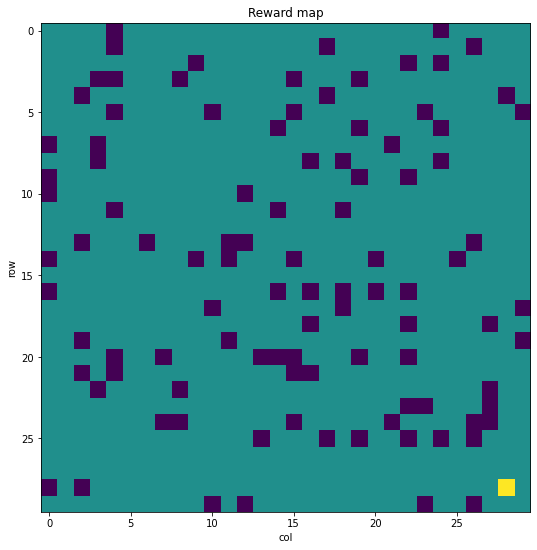

In [55]:
e.showmap()

In [56]:
a.trainDNN(100, 40, 32, False) 

episode: 1/100, score: 8, e: 0.90
episode: 2/100, score: 1, e: 0.90
episode: 3/100, score: 1, e: 0.90
episode: 4/100, score: 1, e: 0.90
episode: 5/100, score: 1, e: 0.90
episode: 6/100, score: 1, e: 0.90
episode: 7/100, score: 6, e: 0.90
episode: 8/100, score: 3, e: 0.90
episode: 9/100, score: 1, e: 0.90
episode: 10/100, score: 36, e: 0.69
episode: 11/100, score: 28, e: 0.53
episode: 12/100, score: 11, e: 0.48
episode: 13/100, score: 1, e: 0.48
episode: 14/100, score: 1, e: 0.48
episode: 15/100, score: 1, e: 0.48
episode: 16/100, score: 1, e: 0.48
episode: 17/100, score: 1, e: 0.48
episode: 18/100, score: 10, e: 0.44
episode: 19/100, score: 1, e: 0.44
episode: 20/100, score: 1, e: 0.44
episode: 21/100, score: 20, e: 0.36
episode: 22/100, score: 29, e: 0.27
episode: 23/100, score: 2, e: 0.27
episode: 24/100, score: 15, e: 0.23
episode: 25/100, score: 5, e: 0.22
episode: 26/100, score: 3, e: 0.22
episode: 27/100, score: 6, e: 0.21
episode: 28/100, score: 4, e: 0.20
episode: 29/100, score

In [57]:
startpos = (24,1)
shortestpath = a.run(startpos)

In [58]:
print(shortestpath)

[(24, 1)]


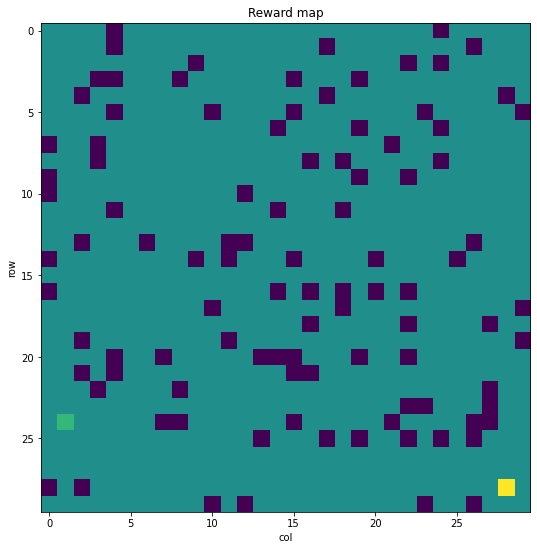

In [59]:
e.showpath(startpos, shortestpath)

In [60]:
print(shortestpath)

[(24, 1)]
